# 11. 메타 학습
## 11.2 MAML - 회귀문제

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/pytorch_dlbro

/content/gdrive/My Drive/pytorch_dlbro


In [ ]:
# GPU vs CPU
# 현재 가능한 장치를 확인한다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

class SinusoidalFunction:
    def __init__(self, x_range=5, k=5, num_tasks=4):
        self.x_range = x_range #[-x_range, x_range]
        self.pi = torch.acos(torch.zeros(1)).item() * 2
        self.k = k
        self.num_tasks = num_tasks

    def meta_train_data(self):
        # Sinusoidal function
        # y = a*sin(x+b)
        x_points = 2*self.x_range*(torch.rand((self.num_tasks, 2*self.k))-0.5) # S and Q
        y_points = torch.tensor([], dtype=torch.float)
   
        for x in x_points:
            a = 4 * (torch.rand(1) + 0.1)
            b = self.pi * torch.rand(1) # [0, pi]
            y = a * torch.sin(x.view(1,-1) + b)
            y_points = torch.cat((y_points, y), 0) 

        taskset = TensorData(x_points, y_points)
        trainloader = torch.utils.data.DataLoader(taskset, batch_size=1)
        return trainloader

    def meta_eval_data(self, k):
        # Check a graph
        x_points = 2*self.x_range*(torch.rand(2*k)-0.5) # S and Q
        a = 4 * (torch.rand(1) + 0.1)
        b = self.pi * torch.rand(1) # [0, pi]
        y_points = a * torch.sin(x_points + b)
        sup_x = x_points[:k]
        sup_y = y_points[:k]
        que_x = x_points[k:]
        que_y = y_points[k:]
        x = torch.linspace(-self.x_range,self.x_range,200)
        y = a * torch.sin(x + b)
        return sup_x, sup_y, que_x, que_y, x, y

In [ ]:
k = 5
num_tasks = 2000
sine = SinusoidalFunction(k=k, num_tasks=num_tasks)
trainloader = sine.meta_train_data()

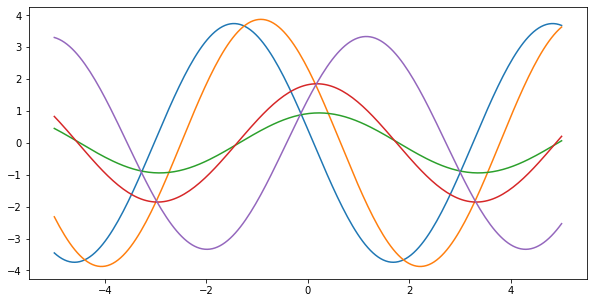

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(5):
    _, _, _, _, x, y = sine.meta_eval_data(5)
    plt.plot(x, y)
plt.show()
plt.close()

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(1, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 1)
        
    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def parameterised(self, x, weights):
        x = F.relu(F.linear(x, weights[0], weights[1]))
        x = F.relu(F.linear(x, weights[2], weights[3]))
        x = F.linear(x, weights[4], weights[5])
        return x    

In [ ]:
class MAML:

    def __init__(self, trainloader, k, alpha = 1e-2, beta = 1e-3):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
        self.k = k
        self.model = Regressor().to(device)
        self.weights = list(self.model.parameters())
        self.trainloader = trainloader
        self.beta = beta
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.weights, lr=alpha)

    def inner_loop(self, data):
        temp_weights = [w.clone() for w in self.weights]
        
        inputs, values = data[0].to(device), data[1].to(device)
        support_x = inputs[:,:self.k].T
        support_y = values[:,:self.k].T
        query_x = inputs[:,self.k:].T
        query_y = values[:,self.k:].T

        outputs = self.model.parameterised(support_x, temp_weights)
        loss = self.criterion(outputs, support_y)
        grad = torch.autograd.grad(loss, temp_weights)
        tmp = [w - self.beta * g for w, g in zip(temp_weights, grad)]
            
        outputs = self.model.parameterised(query_x, tmp)    
        inner_loss = self.criterion(outputs, query_y)

        return inner_loss

    def meta_train(self, num_epochs):      
        n = len(self.trainloader)
        loss_list = []
 
        for epoch in range(num_epochs):
            self.optimizer.zero_grad()
            outer_loss = 0

            for data in self.trainloader:
                outer_loss += self.inner_loop(data)
                
            avg_loss = outer_loss/n
            avg_loss.backward()
            self.optimizer.step()
            ll = avg_loss.item()
            loss_list.append(ll)

            if epoch % 10 == 0:
                print(epoch, ll)

        return loss_list

In [ ]:
maml = MAML(trainloader, k=k)
loss = maml.meta_train(201)

0 4.026951313018799
10 2.9715676307678223
20 2.770207166671753
30 2.680354118347168
40 2.5964608192443848
50 2.514030694961548
60 2.4383111000061035
70 2.3809008598327637
80 2.341686725616455
90 2.3177144527435303
100 2.3043980598449707
110 2.293926954269409
120 2.281930446624756
130 2.2735140323638916
140 2.264514684677124
150 2.2571775913238525
160 2.2644500732421875
170 2.2406277656555176
180 2.231168746948242
190 2.2210512161254883
200 2.2063934803009033


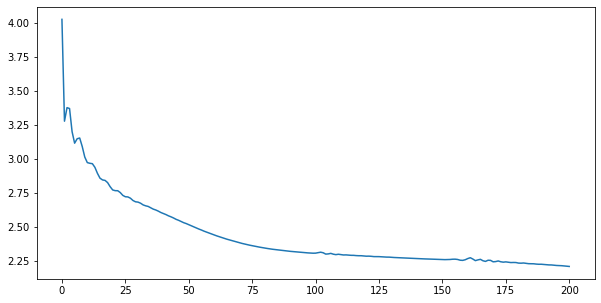

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss)
plt.show()

In [ ]:
def inference(sup_x, sup_y, x, y, model):
    with torch.no_grad():
        pred = model(x.view(-1,1).to(device))
        plt.figure(figsize=(10, 5))
        plt.plot(x.cpu().detach(), pred.cpu().detach(),'-b')
        plt.plot(sup_x.cpu().detach(), sup_y.cpu().detach(),'.g')
        plt.plot(x, y,'--r')
        plt.legend(['prediction','actual points','actual graph'])
        plt.show()
        plt.close()

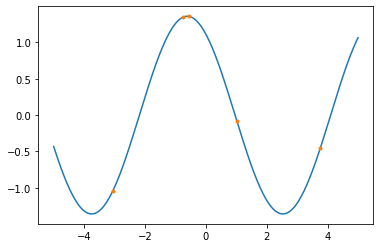

In [ ]:
sup_x, sup_y, _, _, x, y = sine.meta_eval_data(5)
plt.plot(x, y)
plt.plot(sup_x, sup_y, '.')
plt.show()
plt.close()

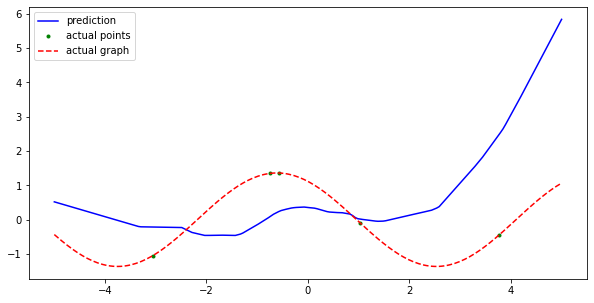

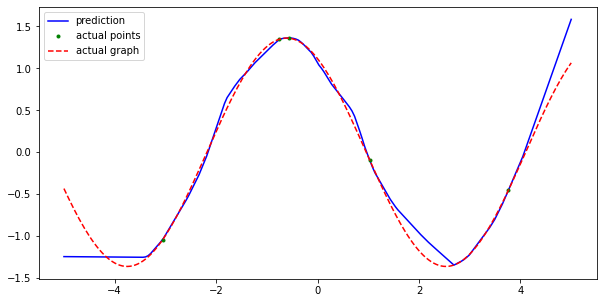

In [ ]:
pre = maml.model
criterion = nn.MSELoss()
optimizer = optim.Adam(pre.parameters(), lr=1e-3)
num_epochs = 1001
for i in range(num_epochs):
    optimizer.zero_grad()
    outputs = pre(sup_x.view(-1,1).to(device))
    loss = criterion(outputs, sup_y.view(-1,1).to(device))
    loss.backward()
    optimizer.step()
    if i == 0:
        inference(sup_x, sup_y, x, y, pre)
    elif  i == num_epochs-1: 
        inference(sup_x, sup_y, x, y, pre) 

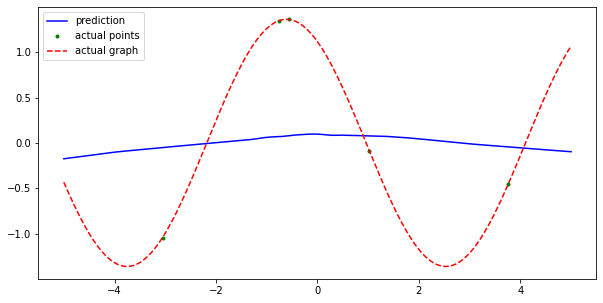

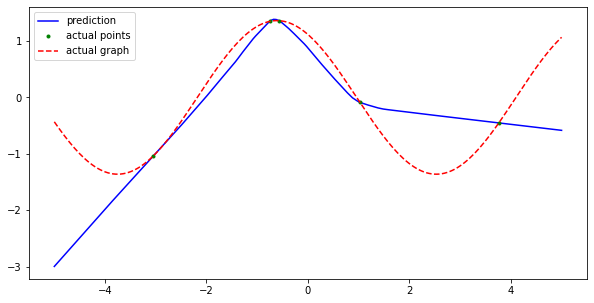

In [ ]:
net = Regressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

for i in range(num_epochs):
    optimizer.zero_grad()
    outputs = net(sup_x.view(-1,1).to(device))
    loss = criterion(outputs, sup_y.view(-1,1).to(device))
    loss.backward()
    optimizer.step()
    if i == 0:
        inference(sup_x, sup_y, x, y, net)
    elif i == num_epochs-1:  
        inference(sup_x, sup_y, x, y, net)